# RNNs para Martín Fierro [Versión 2020]

El objetivo de los ejercicios en este tutorial es mostrar el impacto de algunas decisiones de diseño en la implementación de las redes neuronales, particularmente las recurrentes. Como ejemplo veremos una implementación de la red RNN para generación de lenguaje basada en caracteres de [Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Para entrenarla utilizaremos un fragmento del Martín Fierro que pueden descargar [aquí](https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt). Para un entrenamiento más complejo, pueden utilizar las obras completas de borges, disponibles en [este link](https://drive.google.com/file/d/0B4remi0ZCiqbUFpTS19pSmVFYkU/view?usp=sharing).


In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=81d243acf270013267d33a9c91100717913eb7c6bdea772f765d835e8078e6e7
  Stored in directory: /home/adrian/.var/app/com.jetbrains.PyCharm-Community/cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import random
import re
import sys
import os
import wget
import unicodedata

Primero leeremos el dataset del archivo de texto y lo preprocesaremos para disminuir la viariación de caracteres. Normalizaremos el formato unicos, elminaremos espacios y transformaremos todo a minúsculas.

In [3]:
if not os.path.exists('martin_fierro.txt'):
    wget.download('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt')

100% [..............................................................................] 35910 / 35910

In [4]:
with open('./martin_fierro.txt', 'r') as finput:
    text = unicodedata.normalize('NFC', finput.read()).lower()
    text = re.sub('\s+', ' ', text).strip()

print('Corpus length: %d' % len(text))

Corpus length: 33858


Luego, contaremos la cantidad de caracteres únicos presentes en el texto, y le asignaremos a cada uno un índice único y secuencial. Este índice será utilizado luego para crear las representaciones one-hot encoding de los caracteres.

In [5]:
chars = sorted(list(set(text)))

print('Total chars: %d' % len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total chars: 54


## Language Modeling

La tarea de Language Modiling (**LM**) es aprender $P_{\theta}$ parametrizada por $\theta$ para determinar $P_{\theta}(x|x_1,...x_t)$, donde $x$ puede ser caracter o palabra.

$LM(x, x_1, ..., x_t) = P_{\theta}(x | x_1,...x_t)$

Para la tarea de generación, la tarea de **LM** es la ideal: dada una secuencia de entrada $x_1, ..., x_t$, podemos predecir la palabra de mayor probabilidad según nuestra probabilidad $P$.

$GenerationLM(x_1, ..., x_t) = max_{x} P_{\theta, x_1,...x_t}(x)$

Otra opción, sería sortear la siguiente palabra con respecto a la distribución generada, es decir, samplear $x \sim P_{\theta, x_1,...x_t}$.

## Parte 1: Esqueleto de la red neuronal

Lo primero que debemos pensar es cómo será la arquitectura de nuestra red para resolver la tarea deseada. En esta sección crearemos el modelo sequencial con PyTorch que representará nuestra red. En los pasos siguientes, implementaremos las transformaciones del corpus, por lo que en este paso pueden asumir cualquier formato en los datos de entrada.

Para poder implementar el modelo debemos responder las siguientes preguntas:
  - ¿Es una red one-to-one, one-to-many, many-to-one o many-to-many?
  - ¿Cuál es el formato de entrada y de salida de la red? ¿Cuál es el tamaño de las matrices (tensores) de entrada y de salida?
  - Luego de que la entrada pasa por la capa recurrente, ¿qué tamaño tiene el tensor?
  - ¿Cómo se conecta la salida de la capa recurrente con la capa densa que realiza la clasificación?
  - ¿Cuál es el loss apropiado para este problema?

Primero importamos los módulos que necesitaremos para implementar nuestra red:
  - torch: acceso a todo el framework
  - torch.nn: nos da acceso a capas ya implementadas y a la clase Module para instanciar y crear nuestra red
  

In [6]:
import torch
import torch.nn as nn

# Check if we have a GPU available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')

In [7]:
class MyModel(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_layer,
                 num_layers=1, dropout=0., bias=True,
                 bidirectional=False):
        
        super(MyModel, self).__init__()
        
        # Set our LSTM parameters
        self.lstm_config = {'input_size': input_size,
                            'hidden_size': hidden_layer,
                            'num_layers': num_layers,
                            'bias': bias,
                            'batch_first': True,
                            'dropout': dropout,
                            'bidirectional': bidirectional}
        
        # Set our FC layer parameters
        self.linear_config = {'in_features': hidden_layer,
                              'out_features': vocab_size,
                              'bias': bias}
        
        # Instanciate the layers
        self.encoder = nn.LSTM(**self.lstm_config)
        self.decoder = nn.Sequential()
        self.decoder.add_module('linear', nn.Linear(**self.linear_config))
        self.decoder.add_module('softmax',nn.LogSoftmax(dim=-1))

    def forward(self, inputs):
        outputs, _ = self.encoder(inputs)
        predictions = self.decoder(outputs)
        return predictions

In [8]:
model = MyModel(len(chars), len(chars), 128)
print(model)

MyModel(
  (encoder): LSTM(54, 128, batch_first=True)
  (decoder): Sequential(
    (linear): Linear(in_features=128, out_features=54, bias=True)
    (softmax): LogSoftmax(dim=-1)
  )
)


## Parte 2: Transformación del input

Una vez que definimos la arquitectura de la red, sabemos con exactitud cuál es el input que necesitamos utilizar. En esta sección transformaremos el texto que leimos del archivo en ejemplos de entrenamiento para nuestra red. El resultado será una matrix que representa las secuencias de caracteres y una matriz que representa las etiquetas correspondientes.

  - ¿Cómo debemos representar cada ejemplo?
  - ¿Cómo debemos representar cada etiqueta?
  
Usaremos la clase torch.Dataset para implementar nuestro. Necesitamos implementar dos métodos para esto:
  - \__len__: retorna el largo del dataset
  - \__getitem__: dado un id, retorna el elemento asociado en el dataset con ese id

In [9]:
from torch.utils.data import Dataset, DataLoader

In [10]:
class MartinFierroDataset(Dataset):
    def __init__(self, textdata, maxlen):
        
        self.maxlen = maxlen

        # cut the text in sequences of maxlen characters
        sentences = []
        next_chars = []
        for i in range(0, len(textdata) - maxlen - 1, maxlen):
            sentences.append(textdata[i: i + maxlen])
            next_chars.append(textdata[i + 1: i + maxlen + 1])
        self.length = len(sentences)

        self.X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.float32)
        self.y = np.zeros((len(sentences), maxlen), dtype=np.float32)
        for i, sentence in enumerate(sentences):
            for t, char in enumerate(sentence):
                self.X[i, t, char_indices[char]] = 1
                self.y[i, t] = char_indices[next_chars[i][t]]
        
        print('NB sequences:', self.length)
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx):
        output = {'X': self.X[idx],
                  'y': self.y[idx]}
        return output

In [11]:
data = MartinFierroDataset(text, 50)

NB sequences: 677


## Parte 3: Entrenamiento de la red

En esta sección entrenaremos nuestra red. Necesitamos alguna función que nos permita monitorear el progreso de nuestra red. Para eso vamos a imprimir una muestra del texto generado por la red cada cierta cantidad de epochs.

Utilizaremos dos funciones que toman una porción de texto aleatorio y generan nuevos caracteres con el modelo dado. 

    - ¿Cómo podemos interpretar la salida de la red? ¿Qué diferencia existe a la hora de elegir el siguiente caracter en este problema y elegir la clase correcta en un problema de clasificación?
    - ¿Qué hacen estas funciones? ¿Para qué se utiliza la variable diversity?

In [12]:
def temperature_sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array\n"
    temp_preds = np.asarray(preds[:,-1,:]).astype('float64') / temperature
    exp_preds = np.exp(temp_preds)
    new_probs = (exp_preds / np.sum(exp_preds)).squeeze()
    probas = np.random.multinomial(1, new_probs, 1)
    return np.argmax(probas)

def print_sample(model, device, maxlen=50):
    with torch.no_grad():
        model.eval()
        sample_size = 200
        start_index = random.randint(0, len(text) - maxlen - 1)

        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print()
            print('----- diversity:', diversity)

            sentence = text[start_index: start_index + maxlen]
            #sentence = 'el bien perdido'
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(sentence)

            # Printing the sample
            for i in range(sample_size):
                x = np.zeros((1, maxlen, len(chars)), dtype=np.float32)
                # Build the one-hot encoding for the sentence
                for t, char in enumerate(sentence):
                    x[0, t, char_indices[char]] = 1.

                input_tensor = torch.tensor(x).to(device)
                    
                logprob_preds = model(input_tensor)
                next_index = temperature_sample(logprob_preds.cpu().numpy(), diversity)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

### Entrenamiento

Primero configuramos los hiperparámetros de la red. En este momento determinamos lo siguiente:
  -  learning_rate
  -  epochs
  -  función de pérdida
  -  optimizador
  
También definimos los parámetros para torch.DataLoader, clase que implementa un manejador del dataset que nos dividirá los datos en batches (y los distribuirá entre distintos nodos de cómputo, en caso de contar con multi GPU).

In [13]:
import torch.optim as optim

learning_rate = 0.001
epochs = 22
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

dataloader_config = {'dataset': data,
                     'batch_size': 32,
                     'shuffle': True,
                     'num_workers': 0,
                     'pin_memory': use_cuda}

# Send the model to GPU if there is one available
model.to(device)

MyModel(
  (encoder): LSTM(54, 128, batch_first=True)
  (decoder): Sequential(
    (linear): Linear(in_features=128, out_features=54, bias=True)
    (softmax): LogSoftmax(dim=-1)
  )
)

In [14]:
from time import time

historical_loss = torch.FloatTensor()

# Set the model on train mode
model.train()
for epoch in range(1,epochs+1):
    loss = 0
    
    start = time()
    
    # Show samples every 20 epochs
    if epoch % 20 == 0:
        print_sample(model, device)
        model.train()

    train_loss = torch.FloatTensor().to(device)
        
    dataloader = DataLoader(**dataloader_config)
    for i_batch, sample in enumerate(dataloader):
        inputs, gt_out = sample['X'].to(device), sample['y'].to(device)
        preds = model(inputs)
        bs, seqlen, cat = preds.size()

        # preds: batch_size x max_seq_length x len(chars)
        # gt_out: batch_size x max_seq_length
        # NLLLoss expects inputs of the form:
        # N x C x d1 x ... x dt for the input
        # N x d1 x ... x dt for the targets
        # So we transform define N = batch_size x max_seq_length
        # and we keep C = len(chars)
        loss = loss_function(preds.view(bs*seqlen, -1),
                             gt_out.view(bs*seqlen).type(torch.long)).unsqueeze(0)
        
        # Set gradients to 0, backpropagate, make an uptimization
        # update and store the loss for logging purposes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = torch.cat([train_loss, loss])      
        
    print("Epoch %03d, Time taken %.2f, Training-Loss %.5f" % (epoch, time()-start, torch.mean(train_loss)))
    with torch.no_grad():
        historical_loss = torch.cat([historical_loss, torch.mean(train_loss.cpu()).view(1)])

Epoch 001, Time taken 0.29, Training-Loss 3.68962
Epoch 002, Time taken 0.29, Training-Loss 3.10411
Epoch 003, Time taken 0.27, Training-Loss 3.04845
Epoch 004, Time taken 0.28, Training-Loss 3.02201
Epoch 005, Time taken 0.28, Training-Loss 2.98253
Epoch 006, Time taken 0.27, Training-Loss 2.91866
Epoch 007, Time taken 0.27, Training-Loss 2.82848
Epoch 008, Time taken 0.27, Training-Loss 2.74219
Epoch 009, Time taken 0.28, Training-Loss 2.67502
Epoch 010, Time taken 0.28, Training-Loss 2.61472
Epoch 011, Time taken 0.28, Training-Loss 2.55311
Epoch 012, Time taken 0.28, Training-Loss 2.50644
Epoch 013, Time taken 0.28, Training-Loss 2.47091
Epoch 014, Time taken 0.30, Training-Loss 2.42404
Epoch 015, Time taken 0.28, Training-Loss 2.38443
Epoch 016, Time taken 0.28, Training-Loss 2.35476
Epoch 017, Time taken 0.29, Training-Loss 2.32518
Epoch 018, Time taken 0.28, Training-Loss 2.29843
Epoch 019, Time taken 0.28, Training-Loss 2.27531

----- diversity: 0.2
----- Generating with seed: 

## Ejercicios extras

Una vez que hemos implementado la arquitectura básica de la red, podemos comenzar a experimentar con distintas modificaciones para lograr mejores resultados. Algunas tareas posibles son:

 - Agregar más capas recurrentes
 - Probar otros largos de secuencias máximas
 - Agregar capas de regularización y/o dropout
 - Agregar métricas de performance como perplexity y word error rate

## Comprobaciones

Para asegurarnos de que el modelo esté efectivamente entrenando, podemos graficar la función de pérdida en el corpus de validación.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn

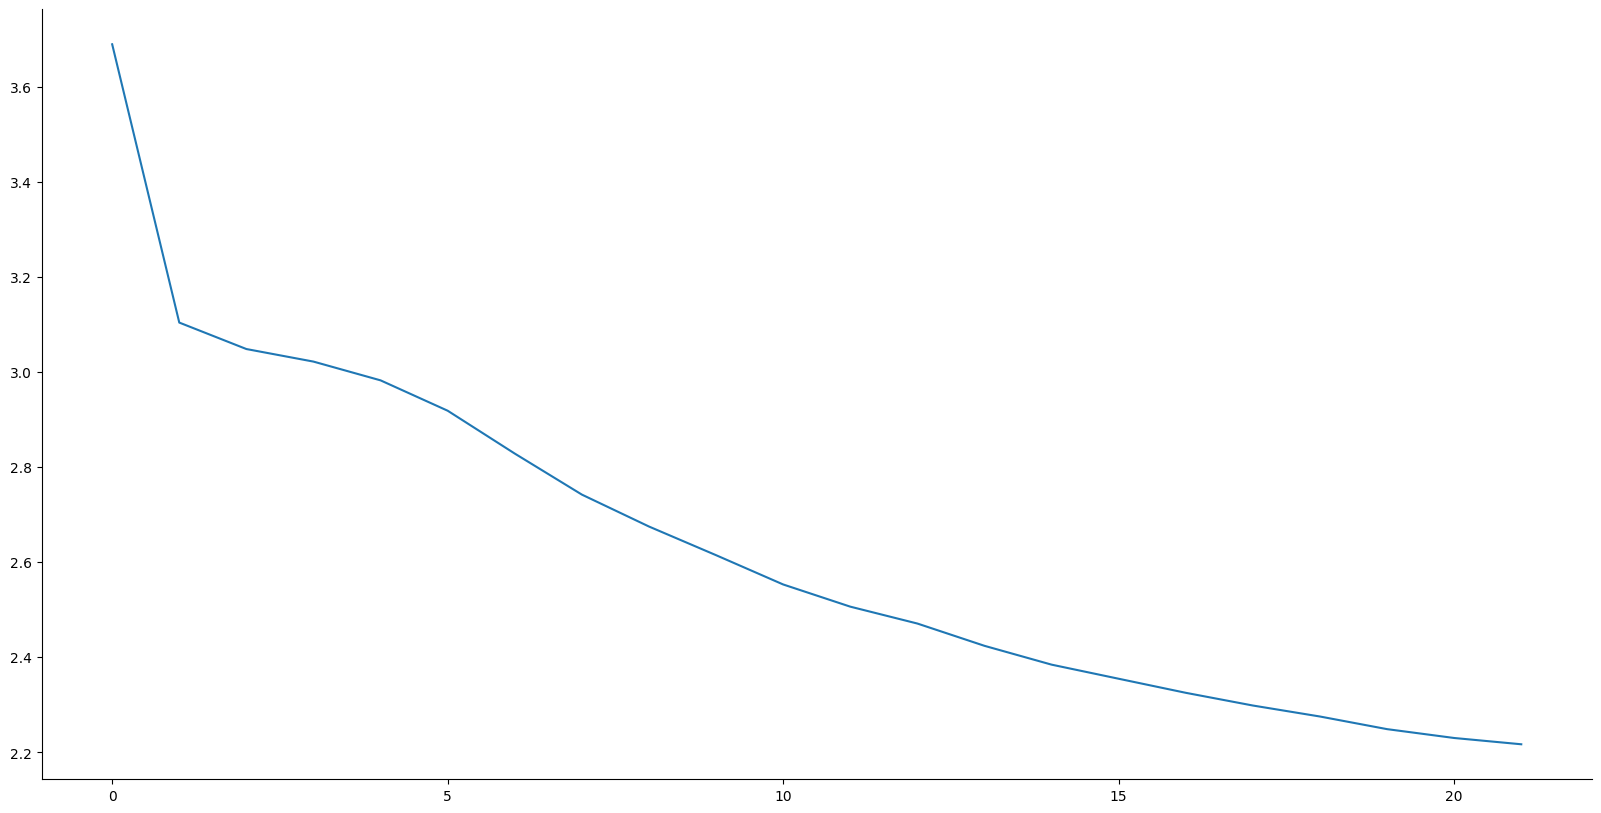

In [16]:
plt.figure(figsize=(20,10))
loss_values = historical_loss.detach().numpy()
seaborn.lineplot(x=range(loss_values.shape[0]), y=loss_values)
seaborn.despine()